## Imports

In [1]:
import pandas as pd
import numpy as np

import nltk
from nltk.corpus import treebank
from nltk.grammar import induce_pcfg
from nltk import Nonterminal, ProbabilisticProduction
from nltk.parse import ViterbiParser

import time
from tqdm import tqdm

from devoir4 import *
import matplotlib.pyplot as plt

## Loading the data

In [2]:
column_names = ["Source_Code", "Acceptability_Label", "Acceptability_Judgment", "Sentence"]

In [3]:
df = pd.read_csv(r"C:\Users\barka\Desktop\NLP\ift6285-devoirs\Devoir 4\data\cola_public\tokenized\in_domain_dev.tsv", delimiter='\t', header=None, names=column_names)
df.head()

,Source_Code,Acceptability_Label,Acceptability_Judgment,Sentence
0,gj04,1,NaN,the sailors rode the breeze clear of the rocks .
1,gj04,1,NaN,the weights made the rope stretch over the pul...
2,gj04,1,NaN,the mechanical doll wriggled itself loose .
3,cj99,1,NaN,"if you had eaten more , you would want less ."
4,cj99,0,*,"as you eat the most , you want the least ."


### Selecting the problematic sentences

In [4]:
problematic_sentences_df = df[df['Acceptability_Label'] == 0]

problematic_sentences_df.head()

,Source_Code,Acceptability_Label,Acceptability_Judgment,Sentence
4,cj99,0,*,"as you eat the most , you want the least ."
5,cj99,0,*,"the more you would want , the less you would e..."
6,cj99,0,*,"i demand that the more john eat , the more he ..."
13,cj99,0,*,"the more does bill smoke , the more susan hate..."
16,bc01,0,*,who does john visit sally because he likes ?


In [5]:
problematic_sentences = problematic_sentences_df["Sentence"].values

## Loading the rules

In [6]:
tic = time.perf_counter()
productions = get_PTB_produtions()
print(f"Took {time.perf_counter() - tic}s.")

[nltk_data] Downloading package treebank to
[nltk_data]     C:\Users\barka\AppData\Roaming\nltk_data...
[nltk_data]   Package treebank is already up-to-date!


Took 10.228337800013833s.


## Solving the unkown word problem

### Selecting the known words from the Pen Treebank dataset

In [7]:
ptb_sentences = treebank.sents()

known_words = set(word.lower() for sentence in ptb_sentences for word in sentence)


### Replacing the unkown words with 'UNK'

In [8]:
unk_token = 'UNK'
modified_sentences = []

for sentence in problematic_sentences:
    words = sentence.split()
    modified_words = [word if word.lower() in known_words else unk_token for word in words]
    modified_sentence = ' '.join(modified_words)
    modified_sentences.append(modified_sentence)
    

In [9]:
modified_sentences[12]

'they represented seriously to the dean mary as a genuine UNK .'

### Adding the A → UNK Rules for any non-terminal A

In [10]:
non_terminals = set([Nonterminal(nt) for sent in modified_sentences for nt in sent.split() if isinstance(Nonterminal(nt), Nonterminal)])

In [11]:
unknown_word = "UNK"

for non_terminal in non_terminals:
    productions.append(ProbabilisticProduction(non_terminal, [unknown_word]))

productions.append(ProbabilisticProduction(Nonterminal("UNK"), [unknown_word]))

In [12]:
for sent in modified_sentences:
    tokens = nltk.word_tokenize(sent)
    for token in tokens:
        productions.append(ProbabilisticProduction(Nonterminal(token), [f"{token}"]))

### Induce a PCFG using all productions

In [13]:
tic = time.perf_counter()
full_grammar = induce_pcfg(Nonterminal("S"), productions)
print(f"Took {time.perf_counter() - tic}s.")

Took 1.2977642000187188s.


## Create Viterbi parser

In [14]:
parser = ViterbiParser(full_grammar)

## Parsing the CoLA dev dataset

In [15]:
all_parses = []

for sentence in tqdm(modified_sentences, desc="Parsing Sentences"):
    tokens = nltk.word_tokenize(sentence)
    parses = parser.parse_all(tokens)
    
    for parse in parses:
        all_parses.append(parse)

Parsing Sentences: 100%|█████████████████████████████████████████████████████████████| 162/162 [39:10<00:00, 14.51s/it]


## Question C Analysis

### Impact of sequence length 

In [16]:
def analyze_subset(sentences, subset_lengths, parser):
    results = []

    for length in tqdm(subset_lengths, desc="Analyzing Subset"):
        subset_sentences = [sentence for sentence in sentences if len(sentence.split()) == length]

        total_time = 0
        total_parses = 0
        unrecognized_count = 0

        for sentence in subset_sentences:
            tokens = nltk.word_tokenize(sentence)


            start_time = time.perf_counter()
            parses = parser.parse_all(tokens)
            end_time = time.perf_counter()
            total_time += end_time - start_time


            total_parses += len(parses)


            if not parses:
                unrecognized_count += 1


        average_time = total_time / len(subset_sentences)
        average_parses = total_parses / len(subset_sentences)


        results.append({
            'Length': length,
            'Average Parsing Time': average_time,
            'Average Number of Parses': average_parses,
            'Unrecognized Sentences': unrecognized_count
        })

    return results

In [17]:
subset_lengths_to_analyze = set(len(sentence.split()) for sentence in modified_sentences)

analysis_results = analyze_subset(modified_sentences, subset_lengths_to_analyze, parser)

Analyzing Subset: 100%|███████████████████████████████████████████████████████████████| 21/21 [43:17<00:00, 123.67s/it]


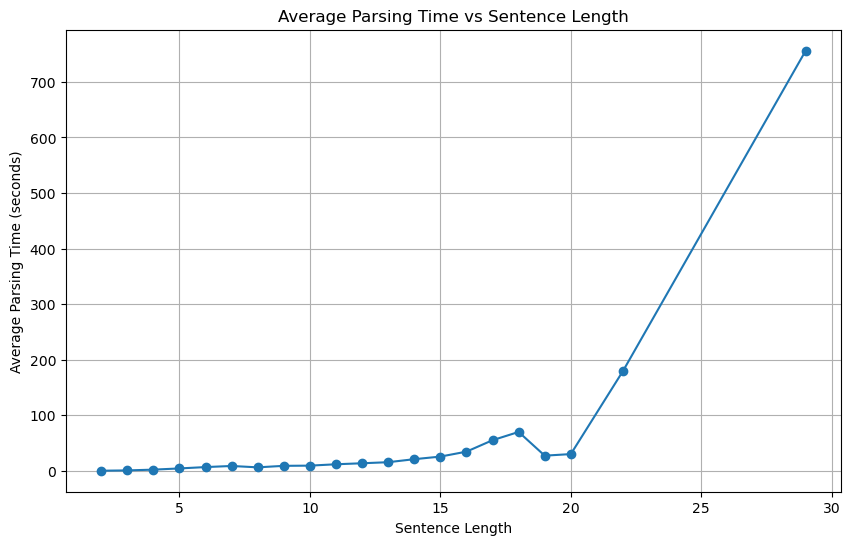

In [18]:
lengths = [result['Length'] for result in analysis_results]
avg_parsing_times = [result['Average Parsing Time'] for result in analysis_results]
avg_num_parses = [result['Average Number of Parses'] for result in analysis_results]
unrecognized_sentences = [result['Unrecognized Sentences'] for result in analysis_results]

plt.figure(figsize=(10, 6))
plt.plot(lengths, avg_parsing_times, marker='o')
plt.title('Average Parsing Time vs Sentence Length')
plt.xlabel('Sentence Length')
plt.ylabel('Average Parsing Time (seconds)')
plt.grid(True)
plt.savefig('average_parsing_time.png')
plt.show()



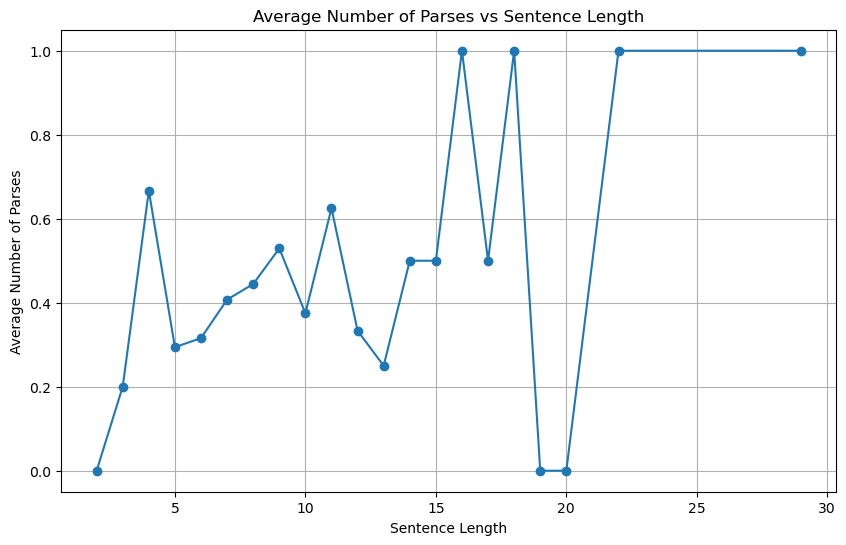

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(lengths, avg_num_parses, marker='o')
plt.title('Average Number of Parses vs Sentence Length')
plt.xlabel('Sentence Length')
plt.ylabel('Average Number of Parses')
plt.grid(True)
plt.savefig('average_num_parses.png')
plt.show()



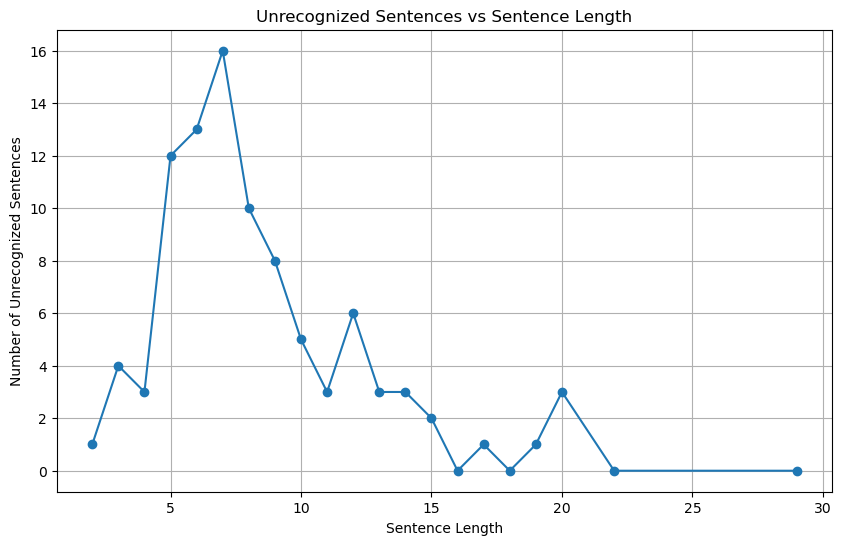

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(lengths, unrecognized_sentences, marker='o')
plt.title('Unrecognized Sentences vs Sentence Length')
plt.xlabel('Sentence Length')
plt.ylabel('Number of Unrecognized Sentences')
plt.grid(True)
plt.savefig('unrecognized_sentences.png')
plt.show()

### Impact of filtiring the grammar

In [21]:
def get_most_frequent_rules(productions, n=1000):
    
    rule_counts = nltk.FreqDist(productions)


    top_n_rules = rule_counts.most_common(n)


    top_n_productions = [rule[0] for rule in top_n_rules]

    return top_n_productions

def induce_filtered_grammar(start_symbol, productions):

    top_rules = get_most_frequent_rules(productions, n=1000)


    filtered_grammar = induce_pcfg(start_symbol, top_rules)

    return filtered_grammar

In [23]:
full_parser = ViterbiParser(full_grammar)
start_symbol = Nonterminal("S")
filtered_grammar = induce_filtered_grammar(start_symbol, productions)
filtered_parser = ViterbiParser(filtered_grammar)

In [24]:
start_time = time.time()

full_parses = []

for sentence in tqdm(modified_sentences, desc="Parsing Sentences - full"):
    tokens = nltk.word_tokenize(sentence)
    parses = full_parser.parse_all(tokens)
    
    for parse in parses:
        full_parses.append(parse)
        
full_parsing_time = time.time() - start_time


start_time = time.time()

filtered_parses = []

for sentence in tqdm(modified_sentences, desc="Parsing Sentences - filtered"):
    tokens = nltk.word_tokenize(sentence)
    parses = full_parser.parse_all(tokens)
    
    for parse in parses:
        filtered_parses.append(parse)
        
filtered_parsing_time = time.time() - start_time

Parsing Sentences - filtered: 100%|██████████████████████████████████████████████████| 162/162 [30:33<00:00, 11.32s/it]


In [25]:
print("Number of Parses (Full Grammar):", len(full_parses))
print("Number of Parses (Filtered Grammar):", len(filtered_parses))

Number of Parses (Full Grammar): 68
Number of Parses (Filtered Grammar): 68


In [26]:
print("Parsing Time (Full Grammar):", full_parsing_time)
print("Parsing Time (Filtered Grammar):", filtered_parsing_time)

Parsing Time (Full Grammar): 1955.3238487243652
Parsing Time (Filtered Grammar): 1833.576720714569
